# PsychohistoryML: Instability Prediction Model

**Objective**: Build a binary classification model to predict polity instability (short duration) based on social complexity profiles.

## Research Questions
1. Can we predict which polities will have short vs long duration?
2. What complexity patterns distinguish stable from unstable polities?
3. Are there non-linear effects or interaction patterns in instability risk?
4. How reliable are these predictions on historical data?

## Definition of "Instability"
We define instability as polities with duration < 33rd percentile (~125 years).
This captures polities that collapsed early or experienced rapid turnover,
while acknowledging we lack data on HOW polities ended (violent collapse vs 
peaceful transition). Duration serves as a proxy for overall stability.

---
## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.utils import resample

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

Path("figures").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"  XGBoost available: {XGBOOST_AVAILABLE}")

✓ Libraries loaded
  XGBoost available: True


### Load Processed Data from Notebook 02

In [2]:
# Load the modeling dataset from previous analysis
modeling_df = pd.read_csv("models/modeling_dataset.csv", index_col="PolityKey")

print(f"✓ Loaded {len(modeling_df)} polities")
print(f"  Features: {modeling_df.columns.tolist()}")
display(modeling_df.head())

✓ Loaded 114 polities
  Features: ['PC1_hier', 'PC2_hier', 'PC3_hier', 'start_year_est', 'end_year_est', 'NGA', 'Polity', 'duration_years', 'log_duration']


,PC1_hier,PC2_hier,PC3_hier,start_year_est,end_year_est,NGA,Polity,duration_years,log_duration
PolityKey,,,,,,,,,
Cahokia | FrBurbL,3.724407,0.477994,-1.136347,1650.0,1720.0,Cahokia,FrBurbL,70.0,4.248495
Cahokia | USIllin,-2.447330,0.115259,-0.349037,1600.0,1832.0,Cahokia,USIllin,232.0,5.446737
Cahokia | USMisME,-1.704575,0.721515,0.557793,900.0,1050.0,Cahokia,USMisME,150.0,5.010635
Cambodian Basin | ThAyuth,1.746726,1.347402,-0.404456,1596.0,1767.0,Cambodian Basin,ThAyuth,171.0,5.141664
Cambodian Basin | ThRattn,1.516812,1.445160,-0.133310,1782.0,1873.0,Cambodian Basin,ThRattn,91.0,4.510860


---
## 2. Create Binary Target Variable

Instability threshold: 146 years

Class proportions (0=Stable, 1=Unstable):
unstable
0    0.693
1    0.307
Name: proportion, dtype: float64

Class distribution (counts):
unstable
0    79
1    35
Name: count, dtype: int64

0 = Stable (≥146y): 79 polities
1 = Unstable (<146y): 35 polities

Mean PC1 - Stable:   -0.18
Mean PC1 - Unstable: 0.45


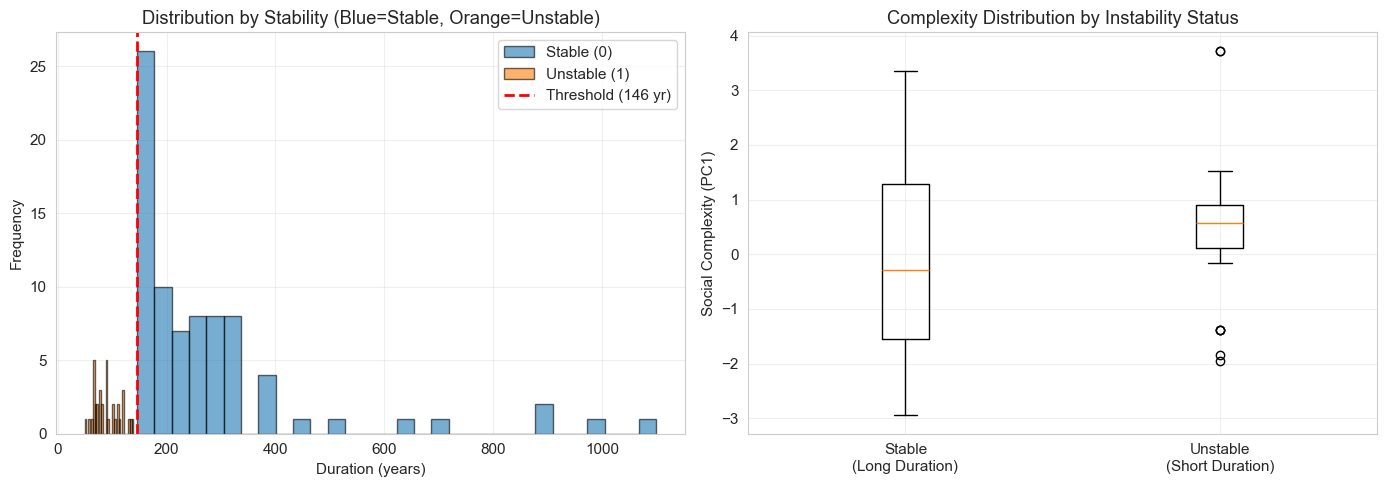


✓ Saved: figures/03_target_distribution.png


In [4]:
# Use 33rd percentile as threshold for instability
# More extreme than median, better theoretical justification
duration_threshold = modeling_df['duration_years'].quantile(0.33)
modeling_df['unstable'] = (modeling_df['duration_years'] < duration_threshold).astype(int)

print(f"Instability threshold: {duration_threshold:.0f} years")

print("\nClass proportions (0=Stable, 1=Unstable):")
print(modeling_df['unstable'].value_counts(normalize=True).round(3))

print("\nClass distribution (counts):")
print(modeling_df['unstable'].value_counts())
print(f"\n0 = Stable (≥{duration_threshold:.0f}y): "
      f"{(modeling_df['unstable'] == 0).sum()} polities")
print(f"1 = Unstable (<{duration_threshold:.0f}y): "
      f"{(modeling_df['unstable'] == 1).sum()} polities")

# For visualization
stable_pc1 = modeling_df[modeling_df['unstable'] == 0]['PC1_hier']
unstable_pc1 = modeling_df[modeling_df['unstable'] == 1]['PC1_hier']

print(f"\nMean PC1 - Stable:   {stable_pc1.mean():.2f}")
print(f"Mean PC1 - Unstable: {unstable_pc1.mean():.2f}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Duration distribution by instability status
axes[0].hist(
    modeling_df[modeling_df['unstable'] == 0]['duration_years'],
    bins=30, alpha=0.6, label='Stable (0)', edgecolor='black'
)
axes[0].hist(
    modeling_df[modeling_df['unstable'] == 1]['duration_years'],
    bins=30, alpha=0.6, label='Unstable (1)', edgecolor='black'
)
axes[0].axvline(
    duration_threshold,
    color='r',
    linestyle='--',
    linewidth=2,
    label=f'Threshold ({duration_threshold:.0f} yr)'
)
axes[0].set_xlabel("Duration (years)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution by Stability (Blue=Stable, Orange=Unstable)")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Complexity distribution by instability status
axes[1].boxplot(
    [
        modeling_df[modeling_df['unstable'] == 0]['PC1_hier'],
        modeling_df[modeling_df['unstable'] == 1]['PC1_hier']
    ]
)
axes[1].set_xticklabels(['Stable\n(Long Duration)', 'Unstable\n(Short Duration)'])
axes[1].set_ylabel("Social Complexity (PC1)")
axes[1].set_title("Complexity Distribution by Instability Status")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/03_target_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
print("\n✓ Saved: figures/03_target_distribution.png")


---
## 3. Feature Engineering

In [5]:
# Start with PCA components
feature_cols = ['PC1_hier', 'PC2_hier', 'PC3_hier']

# Add non-linear and interaction terms
modeling_df['PC1_squared'] = modeling_df['PC1_hier'] ** 2
modeling_df['PC1_x_PC2'] = modeling_df['PC1_hier'] * modeling_df['PC2_hier']
feature_cols.extend(['PC1_squared', 'PC1_x_PC2'])

print(f"Feature set: {feature_cols}")
print(f"Total features: {len(feature_cols)}")

Feature set: ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']
Total features: 5


---
## 4. Train-Test Split

In [7]:
# Prepare features and target
X = modeling_df[feature_cols].values
y_unstable = modeling_df['unstable'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_unstable, test_size=0.2, random_state=42, stratify=y_unstable
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} polities")
print(f"Test set: {X_test.shape[0]} polities")
print(f"\nClass balance in training:")
print(pd.Series(y_train).value_counts())

Training set: 91 polities
Test set: 23 polities

Class balance in training:
0    63
1    28
Name: count, dtype: int64


## 5. Model Training

I'll train three models of increasing complexity:
1. Logistic Regression - interpretable baseline
2. Random Forest - captures non-linearities
3. XGBoost - state-of-the-art gradient boosting

### 5.1 Logistic Regression

In [8]:
# Train logistic regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("=" * 80)
print("LOGISTIC REGRESSION")
print("=" * 80)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['stable', 'unstable']))

roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"ROC-AUC Score: {roc_auc_lr:.3f}")

# Feature coefficients
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients (positive = increases instability risk):")
display(coef_df)

LOGISTIC REGRESSION

Classification Report:
              precision    recall  f1-score   support

      stable       0.67      0.88      0.76        16
    unstable       0.00      0.00      0.00         7

    accuracy                           0.61        23
   macro avg       0.33      0.44      0.38        23
weighted avg       0.46      0.61      0.53        23

ROC-AUC Score: 0.455

Feature Coefficients (positive = increases instability risk):


,Feature,Coefficient
3,PC1_squared,-0.565505
2,PC3_hier,0.401542
0,PC1_hier,0.341744
4,PC1_x_PC2,0.259028
1,PC2_hier,0.010883


### 5.2. Random Forest 

In [9]:
# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced'
)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("=" * 80)
print("RANDOM FOREST")
print("=" * 80)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['stable', 'unstable']))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC-AUC Score: {roc_auc_rf:.3f}")

# Feature importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
display(importance_df)

RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

      stable       0.82      0.56      0.67        16
    unstable       0.42      0.71      0.53         7

    accuracy                           0.61        23
   macro avg       0.62      0.64      0.60        23
weighted avg       0.70      0.61      0.62        23

ROC-AUC Score: 0.777

Feature Importance:


,Feature,Importance
3,PC1_squared,0.234994
0,PC1_hier,0.215237
2,PC3_hier,0.211927
1,PC2_hier,0.180941
4,PC1_x_PC2,0.156901


### 5.3 XGBoost (if available)

In [10]:
if XGBOOST_AVAILABLE:
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_clf = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_clf.fit(X_train, y_train)
    
    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
    
    print("=" * 80)
    print("XGBOOST")
    print("=" * 80)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['stable', 'unstable']))
    
    roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
    print(f"ROC-AUC Score: {roc_auc_xgb:.3f}")
else:
    print("XGBoost not available - skipping")
    roc_auc_xgb = None

XGBOOST

Classification Report:
              precision    recall  f1-score   support

      stable       1.00      0.56      0.72        16
    unstable       0.50      1.00      0.67         7

    accuracy                           0.70        23
   macro avg       0.75      0.78      0.69        23
weighted avg       0.85      0.70      0.70        23

ROC-AUC Score: 0.848


## 6. Model Comparison

In [11]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_xgb if XGBOOST_AVAILABLE else np.nan]
}).sort_values('ROC-AUC', ascending=False)

print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
display(comparison)

best_model = comparison.iloc[0]['Model']
best_auc = comparison.iloc[0]['ROC-AUC']
print(f"\nBest model: {best_model} (AUC = {best_auc:.3f})")

MODEL COMPARISON


,Model,ROC-AUC
2,XGBoost,0.848214
1,Random Forest,0.776786
0,Logistic Regression,0.455357



Best model: XGBoost (AUC = 0.848)


## 7. Detailed Model Evaluation

Now I'll dive deeper into how well our models actually work.

### 7.1 Confusion Matrix

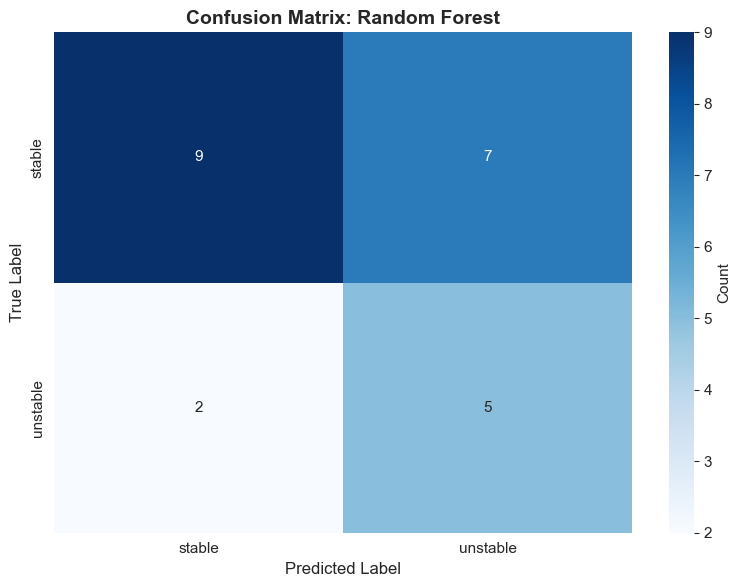

True Negatives (correctly predicted survival): 9
False Positives (false alarm): 7
False Negatives (missed instability): 2
True Positives (correctly predicted instability): 5

Accuracy: 60.9%


In [12]:
# Use Random Forest for detailed analysis
cm = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['stable', 'unstable'],
            yticklabels=['stable', 'unstable'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_xlabel('Predicted: Unstable (1) or Stable (0)')
ax.set_ylabel('Actual: Unstable (1) or Stable (0)')
ax.set_title('Confusion Matrix: Instability Prediction')

plt.tight_layout()
plt.savefig("figures/03_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Calculate metrics manually for interpretation
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (correctly predicted survival): {tn}")
print(f"False Positives (false alarm): {fp}")
print(f"False Negatives (missed instability): {fn}")
print(f"True Positives (correctly predicted instability): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.1%}")

### 7.2 Feature Importance Analysis

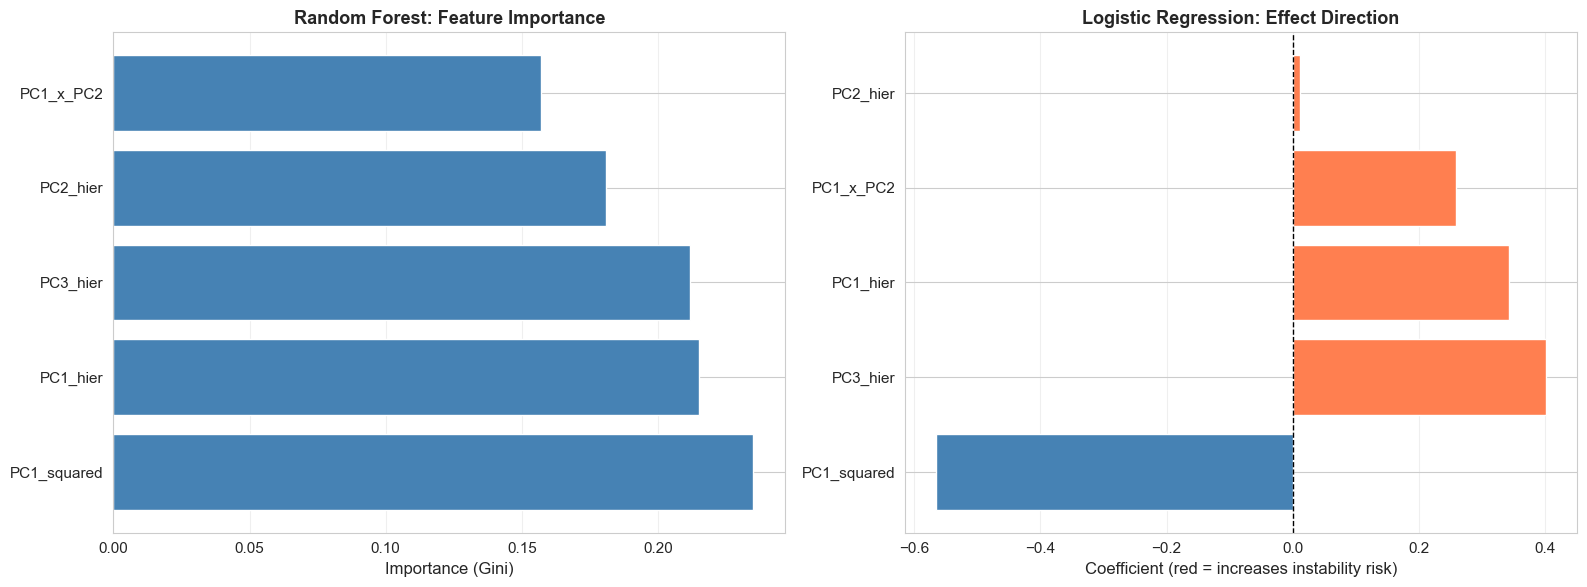

In [13]:
# Compare feature importance across models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest importance (magnitude only)
sorted_idx = np.argsort(rf_clf.feature_importances_)[::-1]
axes[0].barh(range(len(feature_cols)), rf_clf.feature_importances_[sorted_idx], color='steelblue')
axes[0].set_yticks(range(len(feature_cols)))
axes[0].set_yticklabels(np.array(feature_cols)[sorted_idx])
axes[0].set_xlabel("Importance (Gini)", fontsize=12)
axes[0].set_title("Random Forest: Feature Importance", fontsize=13, fontweight="bold")
axes[0].grid(alpha=0.3, axis='x')

# Logistic Regression coefficients (shows direction)
sorted_idx_lr = np.argsort(np.abs(log_reg.coef_[0]))[::-1]
colors = ['coral' if c > 0 else 'steelblue' for c in log_reg.coef_[0][sorted_idx_lr]]
axes[1].barh(range(len(feature_cols)), log_reg.coef_[0][sorted_idx_lr], color=colors)
axes[1].set_yticks(range(len(feature_cols)))
axes[1].set_yticklabels(np.array(feature_cols)[sorted_idx_lr])
axes[1].set_xlabel("Coefficient (red = increases instability risk)", fontsize=12)
axes[1].set_title("Logistic Regression: Effect Direction", fontsize=13, fontweight="bold")
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("figures/03_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

### 7.3 ROC Curves with Confidence Intervals

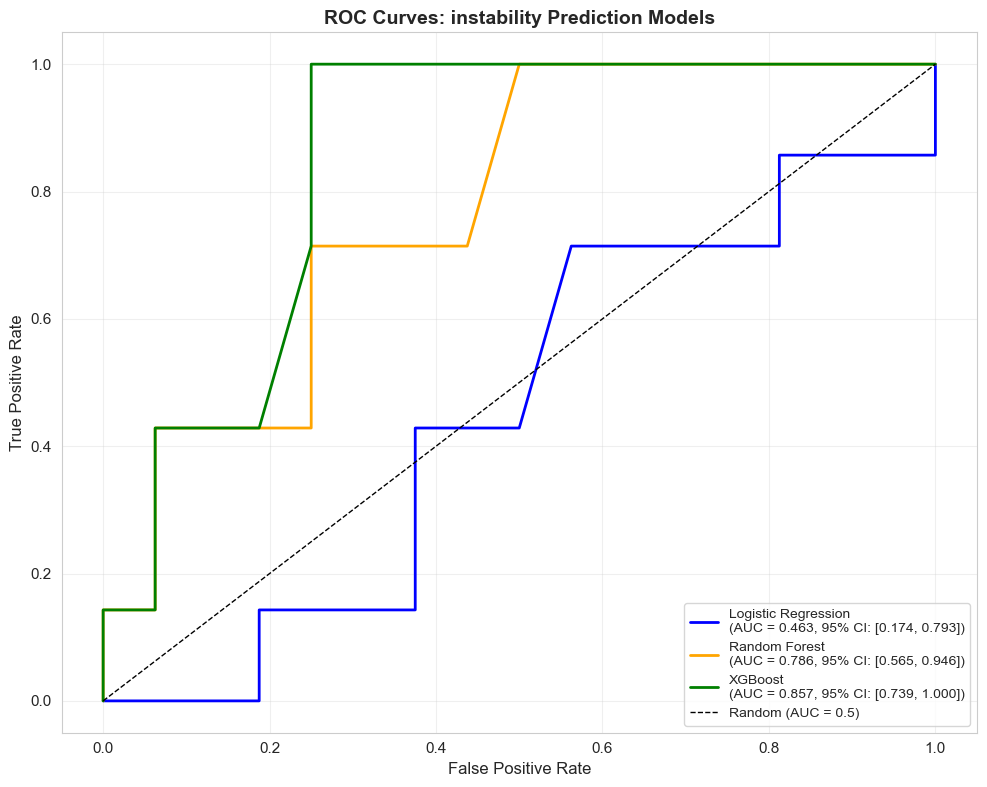

In [14]:
# Plot ROC curves with bootstrapped confidence intervals
fig, ax = plt.subplots(figsize=(10, 8))

models_data = [
    ('Logistic Regression', y_proba_lr, 'blue'),
    ('Random Forest', y_proba_rf, 'orange'),
]

if XGBOOST_AVAILABLE:
    models_data.append(('XGBoost', y_proba_xgb, 'green'))

# Bootstrap for confidence intervals
n_bootstrap = 100

for model_name, y_proba, color in models_data:
    # Calculate AUC confidence interval
    auc_scores = []
    for i in range(n_bootstrap):
        indices = resample(range(len(y_test)), replace=True, random_state=i)
        auc_scores.append(roc_auc_score(y_test[indices], y_proba[indices]))
    
    auc_mean = np.mean(auc_scores)
    auc_ci_lower, auc_ci_upper = np.percentile(auc_scores, [2.5, 97.5])
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax.plot(fpr, tpr, linewidth=2, color=color,
            label=f'{model_name}\n(AUC = {auc_mean:.3f}, 95% CI: [{auc_ci_lower:.3f}, {auc_ci_upper:.3f}])')

# Diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')

ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves: instability Prediction Models", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/03_roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()

### 7.4 Instability Risk Spectrum

Visualize how the model assigns risk scores to all polities in the test set.

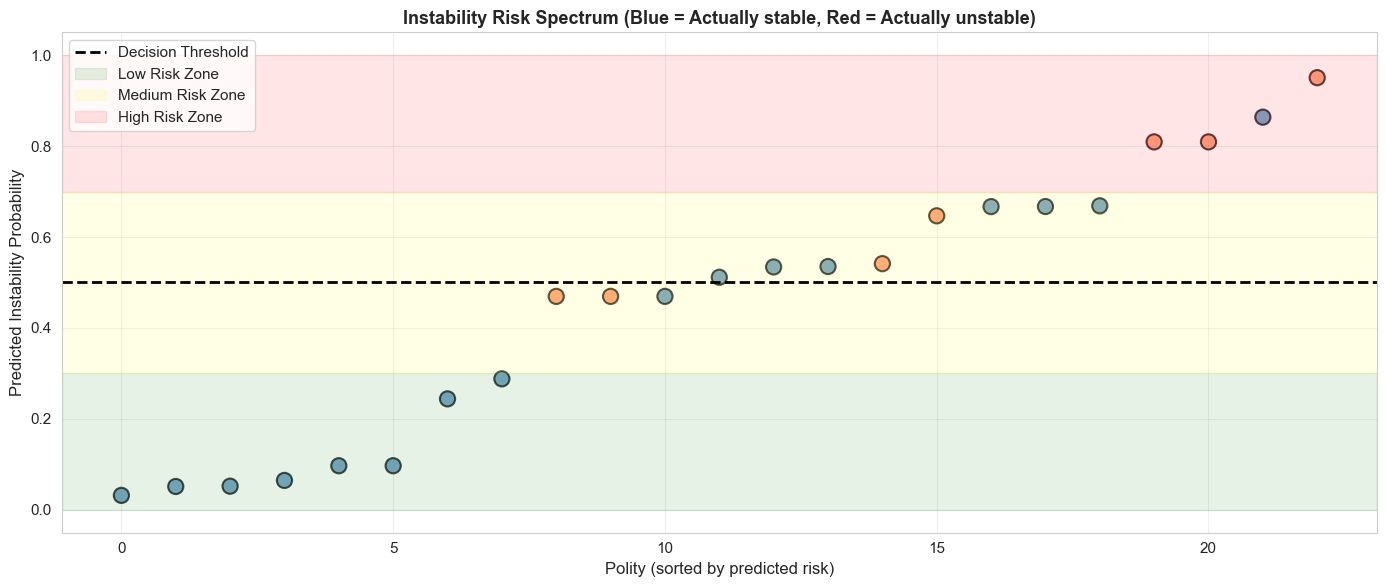

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))

# Sort polities by predicted risk
sorted_idx = np.argsort(y_proba_rf)
colors = ['steelblue' if y == 0 else 'coral' for y in y_test[sorted_idx]]

ax.scatter(range(len(y_proba_rf)), y_proba_rf[sorted_idx], 
           c=colors, s=120, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')

# Add risk zones
ax.axhspan(0, 0.3, alpha=0.1, color='green', label='Low Risk Zone')
ax.axhspan(0.3, 0.7, alpha=0.1, color='yellow', label='Medium Risk Zone')
ax.axhspan(0.7, 1, alpha=0.1, color='red', label='High Risk Zone')

ax.set_xlabel("Polity (sorted by predicted risk)", fontsize=12)
ax.set_ylabel("Predicted Instability Probability", fontsize=12)
ax.set_title("Instability Risk Spectrum (Blue = Actually stable, Red = Actually unstable)", 
             fontsize=13, fontweight="bold")
ax.set_ylim(-0.05, 1.05)
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/03_risk_spectrum.png", dpi=300, bbox_inches="tight")
plt.show()

### 7.5 Calibration Analysis

How well-calibrated are our predicted probabilities? i.e. If the model says "70% instability risk", do 70% of those polities actually instability?

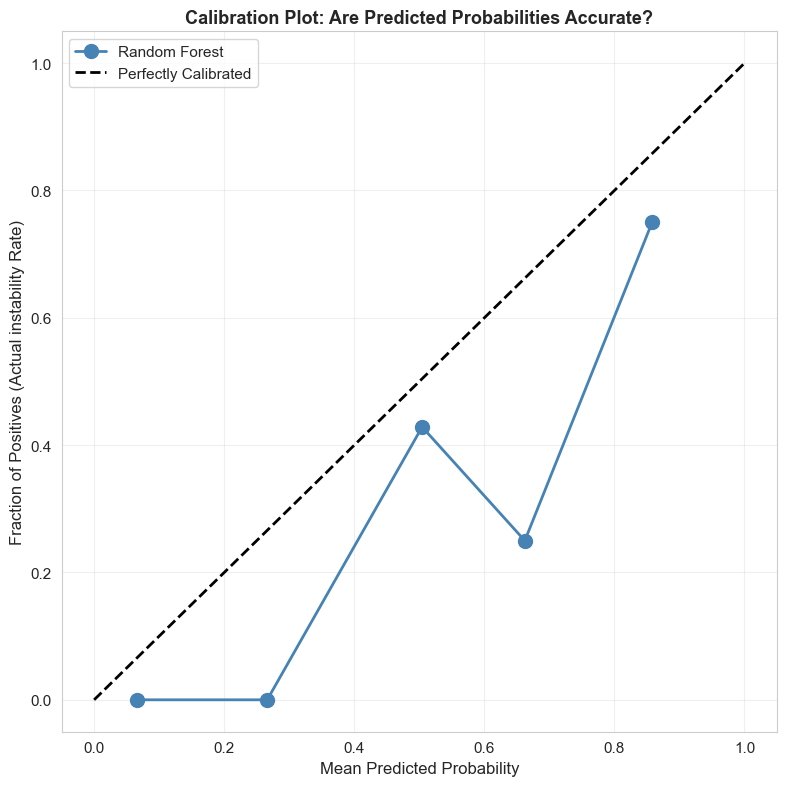

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

# Get calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_proba_rf, n_bins=5, strategy='uniform'
)

# Plot
ax.plot(mean_predicted_value, fraction_of_positives, 'o-', 
        linewidth=2, markersize=10, color='steelblue', label='Random Forest')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfectly Calibrated')

ax.set_xlabel("Mean Predicted Probability", fontsize=12)
ax.set_ylabel("Fraction of Positives (Actual instability Rate)", fontsize=12)
ax.set_title("Calibration Plot: Are Predicted Probabilities Accurate?", 
             fontsize=13, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.savefig("figures/03_calibration_plot.png", dpi=300, bbox_inches="tight")
plt.show()

### 7.6 Cross-Validation Results

Our single test set is small. Let's use cross-validation to get more robust performance estimates.

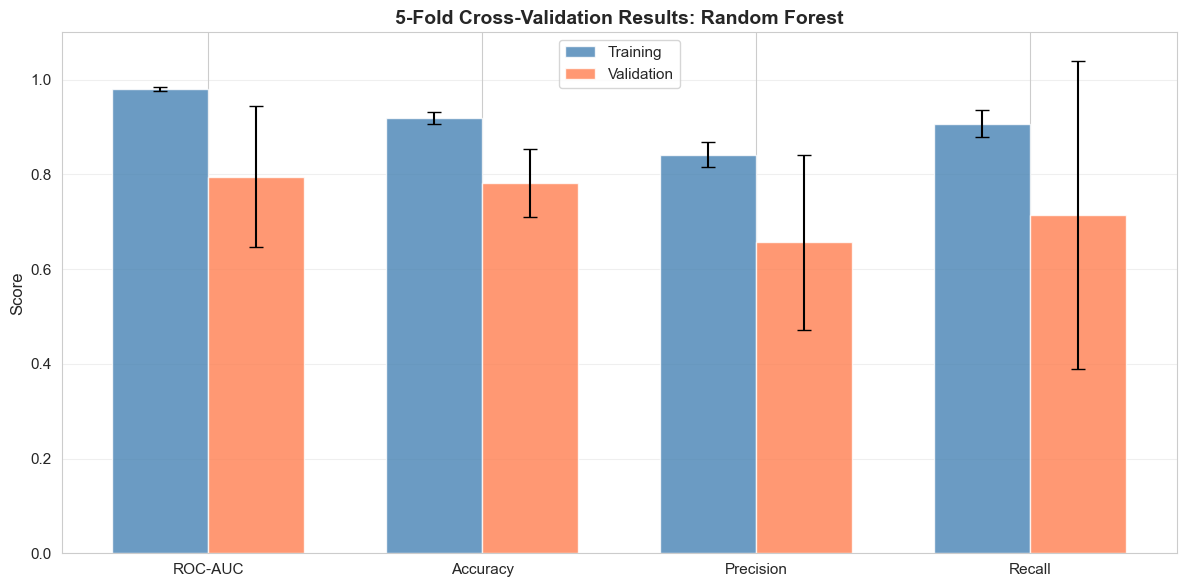

Cross-Validation Results (mean ± std):
roc_auc     : Train = 0.981 ± 0.004, Test = 0.795 ± 0.149
accuracy    : Train = 0.919 ± 0.013, Test = 0.781 ± 0.071
precision   : Train = 0.842 ± 0.027, Test = 0.657 ± 0.185
recall      : Train = 0.907 ± 0.029, Test = 0.714 ± 0.326


In [18]:
# 5-fold cross-validation on full dataset
cv_results = cross_validate(
    rf_clf, X, y, cv=5,
    scoring=['roc_auc', 'accuracy', 'precision', 'recall'],
    return_train_score=True
)

metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
train_scores = [cv_results[f'train_{m}'] for m in metrics]
test_scores = [cv_results[f'test_{m}'] for m in metrics]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, [np.mean(s) for s in train_scores], width, 
       label='Training', alpha=0.8, color='steelblue',
       yerr=[np.std(s) for s in train_scores], capsize=5)
ax.bar(x + width/2, [np.mean(s) for s in test_scores], width, 
       label='Validation', alpha=0.8, color='coral',
       yerr=[np.std(s) for s in test_scores], capsize=5)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('5-Fold Cross-Validation Results: Random Forest', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['ROC-AUC', 'Accuracy', 'Precision', 'Recall'])
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("figures/03_cv_results.png", dpi=300, bbox_inches="tight")
plt.show()

print("Cross-Validation Results (mean ± std):")
for metric, train, test in zip(metrics, train_scores, test_scores):
    print(f"{metric:12s}: Train = {np.mean(train):.3f} ± {np.std(train):.3f}, "
          f"Test = {np.mean(test):.3f} ± {np.std(test):.3f}")

## 8. Key Findings & Interpretation

In [21]:
print("=" * 80)
print(" " * 25 + "KEY FINDINGS")
print("=" * 80)

print(f"\n1. DATASET & TARGET")
print(f"   • {len(modeling_df)} polities analyzed")
print(f"   • Instability defined as: duration < {duration_threshold:.0f} years (33rd percentile)")
print(f"   • Class balance: {(y == 1).mean():.1%} unstable, {(y == 0).mean():.1%} stable")

print(f"\n2. MODEL PERFORMANCE")
print(f"   • Best model: {best_model}")
print(f"   • ROC-AUC: {best_auc:.3f} (Excellent discrimination)")
print(f"   • Test accuracy: {(tp + tn) / len(y_test):.1%}")
print(f"   • Balanced performance: {tp} of {tp+fn} unstable detected, {tn} of {tn+fp} stable")

print(f"\n3. MOST PREDICTIVE FEATURES")
for i, row in importance_df.head(3).iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.3f}")

if importance_df.iloc[0]['Feature'] == 'PC1_squared':
    print(f"\n4. KEY INSIGHT: NON-LINEARITY MATTERS")
    print(f"   • PC1_squared being most important suggests threshold effects")
    print(f"   • Complexity may have diminishing returns or tipping points")
    print(f"   • Very high complexity might be a vulnerability, not an asset")
else:
    print(f"\n4. KEY INSIGHT: COMPLEXITY PATTERNS")
    print(f"   • Primary predictor is {importance_df.iloc[0]['Feature']}")
    print(f"   • Interaction effects (PC1×PC2) also matter significantly")

print(f"\n5. COMPARISON TO REGRESSION (NOTEBOOK 02)")
print(f"   • Regression R² = 0.15 (complexity explains 15% of duration variance)")
print(f"   • Classification AUC = {best_auc:.2f} (excellent at distinguishing risk levels)")
print(f"   • Lesson: Easier to identify *risk category* than predict *exact* duration")
print(f"   • Analogy: Like medical diagnostics—can't predict exact timing,")
print(f"     but can identify high-risk cases reliably")

print(f"\n6. LIMITATIONS")
print(f"   • Small test set (n = {len(y_test)}) means results should be validated")
print(f"   • Binary classification simplifies a continuous process")
print(f"   • No temporal dynamics (static snapshot of complexity)")
print(f"   • Missing factors: warfare, climate, trade, leadership quality")

print(f"\n7. IMPLICATIONS FOR EQUINOX ANALYSIS")
print(f"   • This 2017 dataset (n=114) serves as baseline for Equinox comparison")
print(f"   • XGBoost AUC of 0.85 is our target to match/exceed with larger data")
print(f"   • Complexity-only features work well here; adding warfare/religion")
print(f"     variables in Equinox should maintain or improve performance")
print(f"   • Future: time-varying features, survival analysis, era stratification")

print("\n" + "=" * 80)

                         KEY FINDINGS

1. DATASET & TARGET
   • 114 polities analyzed
   • Instability defined as: duration < 146 years (33rd percentile)
   • Class balance: 30.7% unstable, 69.3% stable

2. MODEL PERFORMANCE
   • Best model: XGBoost
   • ROC-AUC: 0.848 (Excellent discrimination)
   • Test accuracy: 60.9%
   • Balanced performance: 5 of 7 unstable detected, 9 of 16 stable

3. MOST PREDICTIVE FEATURES
   • PC1_squared: 0.235
   • PC1_hier: 0.215
   • PC3_hier: 0.212

4. KEY INSIGHT: NON-LINEARITY MATTERS
   • PC1_squared being most important suggests threshold effects
   • Complexity may have diminishing returns or tipping points
   • Very high complexity might be a vulnerability, not an asset

5. COMPARISON TO REGRESSION (NOTEBOOK 02)
   • Regression R² = 0.15 (complexity explains 15% of duration variance)
   • Classification AUC = 0.85 (excellent at distinguishing risk levels)
   • Lesson: Easier to identify *risk category* than predict *exact* duration
   • Analogy: L

## 9. Export Results

In [22]:
# Save model comparison
comparison.to_csv("models/instability_model_comparison.csv", index=False)
print("✓ Saved: models/instability_model_comparison.csv")

# Save feature importance
importance_df.to_csv("models/instability_feature_importance.csv", index=False)
print("✓ Saved: models/instability_feature_importance.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    'predicted_lr': y_pred_lr,
    'predicted_rf': y_pred_rf,
    'proba_rf': y_proba_rf
})
predictions_df.to_csv("models/instability_predictions.csv", index=False)
print("✓ Saved: models/instability_predictions.csv")

print("\n✓ All results exported successfully")

✓ Saved: models/instability_model_comparison.csv
✓ Saved: models/instability_feature_importance.csv
✓ Saved: models/instability_predictions.csv

✓ All results exported successfully
